In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("skygeni_sales_data.csv")

df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])

df['is_won'] = (df['outcome'].str.lower() == 'won').astype(int)
df['cohort_quarter'] = df['created_date'].dt.to_period('Q')

df['velocity_ratio'] = df['deal_amount'] / df['sales_cycle_days']

benchmark = df[df['is_won']==1]['sales_cycle_days'].mean()
df['rot_index'] = df['sales_cycle_days'] / benchmark


In [105]:
lead_win_table = df.pivot_table(
    index='lead_source',
    columns='cohort_quarter',
    values='is_won',
    aggfunc='mean'
)

lead_win_table

cohort_quarter,2023Q1,2023Q2,2023Q3,2023Q4,2024Q1
lead_source,,,,,
Inbound,0.481013,0.474510,0.468000,0.462406,0.417323
Outbound,0.433333,0.475610,0.450199,0.490196,0.425197
Partner,0.395437,0.386454,0.490566,0.494024,0.428571
Referral,0.443609,0.435115,0.454167,0.473029,0.473251


In [106]:
lead_volume_table = df.pivot_table(
    index='lead_source',
    columns='cohort_quarter',
    values='deal_id',
    aggfunc='count'
)

lead_volume_table


cohort_quarter,2023Q1,2023Q2,2023Q3,2023Q4,2024Q1
lead_source,,,,,
Inbound,237,255,250,266,254
Outbound,240,246,251,255,254
Partner,263,251,265,251,210
Referral,266,262,240,241,243


In [107]:
deal_size_table = df.groupby('lead_source')['deal_amount'].mean().sort_values(ascending=False)

deal_size_table

lead_source
Inbound     27041.867670
Referral    26261.345847
Outbound    25963.354735
Partner     25867.808065
Name: deal_amount, dtype: float64

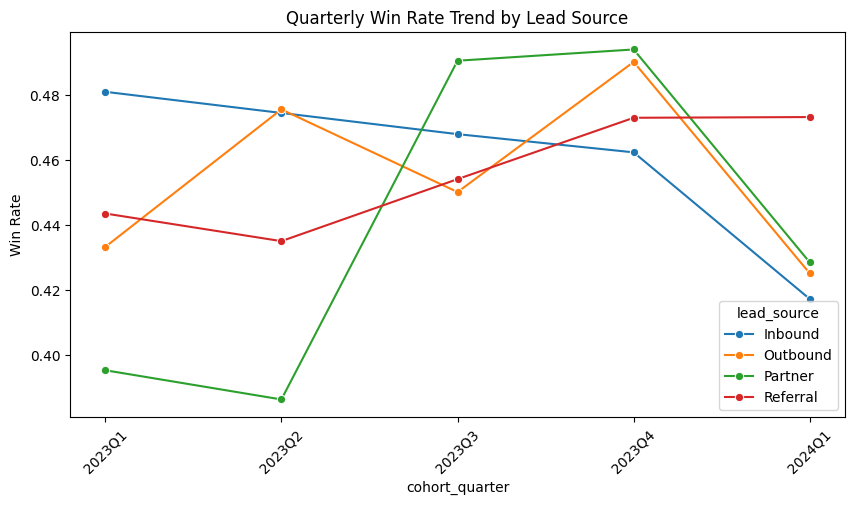

In [108]:
lead_trend = df.groupby(['cohort_quarter','lead_source'])['is_won'].mean().reset_index()
lead_trend['cohort_quarter'] = lead_trend['cohort_quarter'].astype(str)

plt.figure(figsize=(10,5))
sns.lineplot(data=lead_trend,
             x='cohort_quarter',
             y='is_won',
             hue='lead_source',
             marker='o')

plt.title("Quarterly Win Rate Trend by Lead Source")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.show()


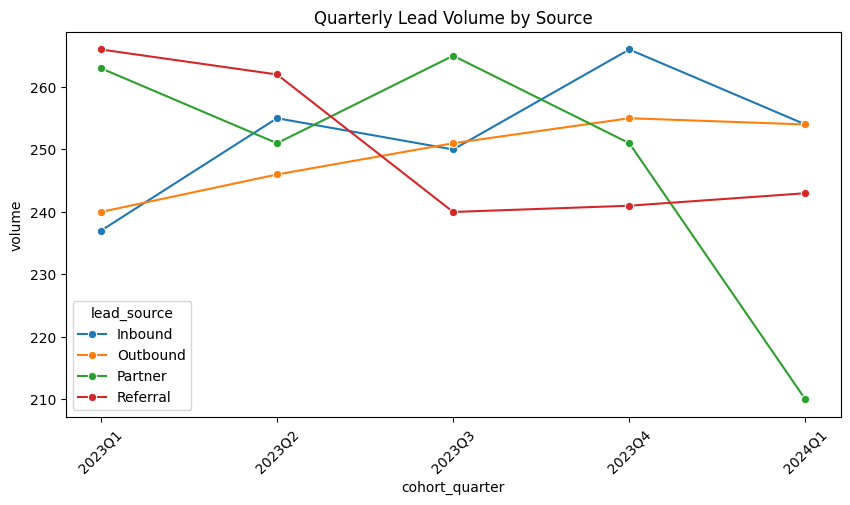

In [109]:
lead_volume = df.groupby(['cohort_quarter','lead_source']).size().reset_index(name='volume')
lead_volume['cohort_quarter'] = lead_volume['cohort_quarter'].astype(str)

plt.figure(figsize=(10,5))
sns.lineplot(data=lead_volume,
             x='cohort_quarter',
             y='volume',
             hue='lead_source',
             marker='o')

plt.title("Quarterly Lead Volume by Source")
plt.xticks(rotation=45)
plt.show()


In [110]:
product_win_table = df.pivot_table(
    index='product_type',
    columns='cohort_quarter',
    values='is_won',
    aggfunc='mean'
)

product_win_table


cohort_quarter,2023Q1,2023Q2,2023Q3,2023Q4,2024Q1
product_type,,,,,
Core,0.420118,0.432584,0.476341,0.501425,0.445783
Enterprise,0.432177,0.436709,0.482759,0.472934,0.416107
Pro,0.458689,0.459064,0.439883,0.463023,0.444109


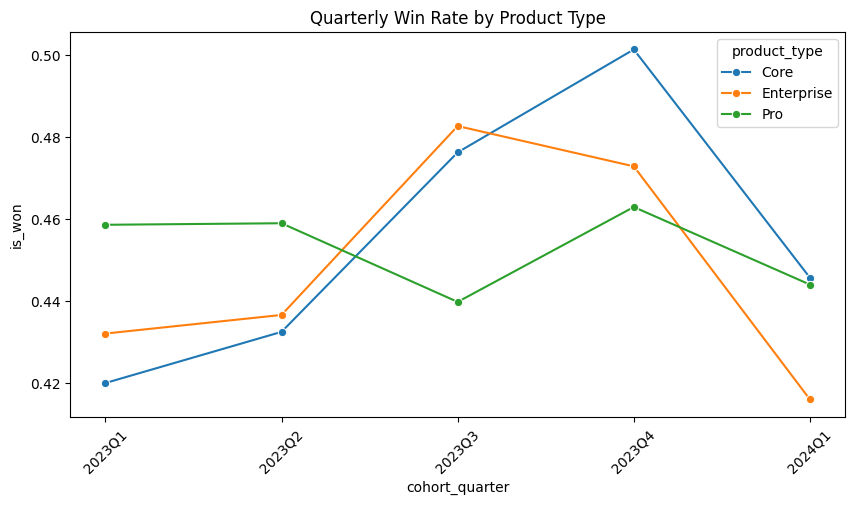

In [111]:
product_trend = df.groupby(['cohort_quarter','product_type'])['is_won'].mean().reset_index()
product_trend['cohort_quarter'] = product_trend['cohort_quarter'].astype(str)

plt.figure(figsize=(10,5))
sns.lineplot(data=product_trend,
             x='cohort_quarter',
             y='is_won',
             hue='product_type',
             marker='o')

plt.title("Quarterly Win Rate by Product Type")
plt.xticks(rotation=45)
plt.show()

In [112]:
revenue_table = df[df['is_won']==1].groupby('product_type')['deal_amount'].sum().sort_values(ascending=False)

revenue_table

product_type
Pro           21041792
Core          20690550
Enterprise    18856936
Name: deal_amount, dtype: int64

In [113]:
stage_dist = df[df['is_won']==1]['deal_stage'].value_counts(normalize=True)*100

stage_dist

deal_stage
Demo           21.122404
Closed         20.592134
Negotiation    20.503756
Proposal       19.929297
Qualified      17.852408
Name: proportion, dtype: float64

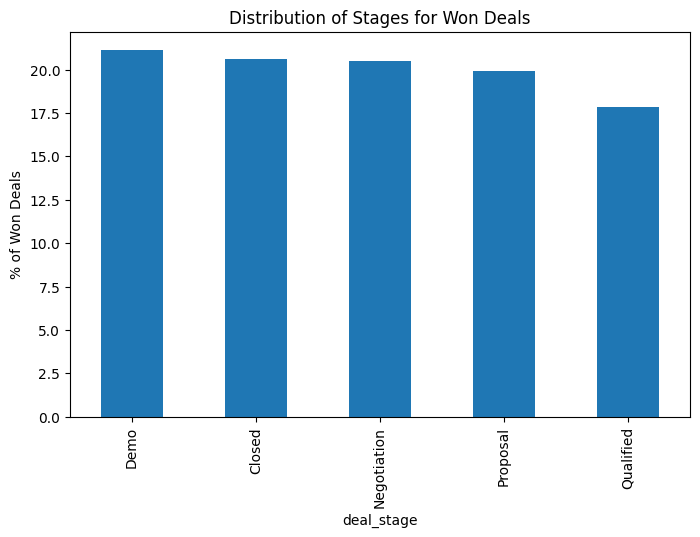

In [114]:
plt.figure(figsize=(8,5))
stage_dist.plot(kind='bar')

plt.title("Distribution of Stages for Won Deals")
plt.ylabel("% of Won Deals")
plt.show()


In [115]:
velocity_stats = df[df['is_won']==1]['velocity_ratio'].describe()

velocity_stats

count     2263.000000
mean       690.006599
std       1232.430196
min         17.948718
25%        111.931994
50%        278.695652
75%        771.113429
max      13715.857143
Name: velocity_ratio, dtype: float64

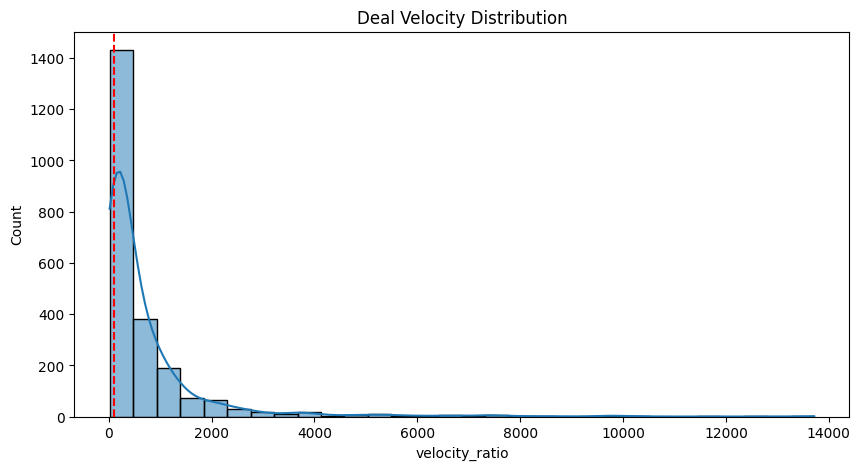

In [116]:
plt.figure(figsize=(10,5))
sns.histplot(df[df['is_won']==1]['velocity_ratio'], bins=30, kde=True)

plt.axvline(df[df['is_won']==1]['velocity_ratio'].quantile(0.25),
            color='red', linestyle='--')

plt.title("Deal Velocity Distribution")
plt.show()


In [117]:
df['rot_band'] = pd.cut(df['rot_index'],
                        bins=[0,1,1.5,3,10],
                        labels=['Fresh','Normal','At Risk','Rotting'])

rot_table = df.groupby('rot_band')['is_won'].mean()

rot_table


rot_band
Fresh      0.459023
Normal     0.448605
At Risk    0.443583
Name: is_won, dtype: float64

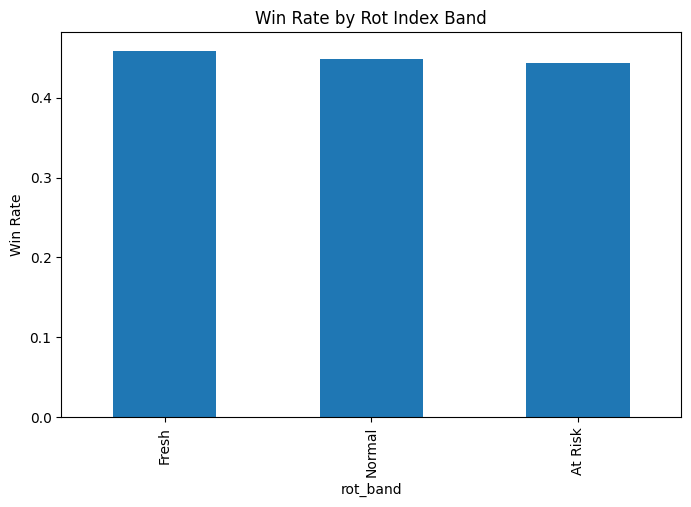

In [118]:
plt.figure(figsize=(8,5))
rot_table.plot(kind='bar')

plt.title("Win Rate by Rot Index Band")
plt.ylabel("Win Rate")
plt.show()